In [1]:
import torch.utils.data as data
import torch
from torchvision import transforms
from PIL import Image
import sys
sys.path.append('..')
# from config import INPUT_SIZE

class GetLoader(data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.transform = transform
        self.data_root = data_root
       # print(self.data_root)
        f = open(self.data_root + data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.labels = []

        for data in data_list:
            image_path = data[:-1]
            label = image_path.split('/')[1]
            self.img_paths.append(image_path)
            self.labels.append(label)

        print(len(set(self.labels)))

        self.label_dict = {}
        for i, label in enumerate(sorted(list(set(sorted(self.labels))))):
            self.label_dict[label] = i
            
        print(self.label_dict)

        

    def __getitem__(self, item):

     #   print(self.data_root)
        img_path, label= self.img_paths[item], self.labels[item]
        #img_path_full = os.path.join(self.data_root, img_path)
        img_path_full = self.data_root+img_path
      #  print(img_path_full)
        img = Image.open(img_path_full).convert('RGB')
        # label = np.array(label,dtype='float32')
        label = self.label_dict[label]
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return self.n_data



In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [3]:
total_trainset = GetLoader(data_root='/userdata/smetzger/data/logos/train_and_test/train/',
        data_list='train_images_root.txt',
        transform=transforms.Compose([
                        transforms.Resize((600, 600), Image.BILINEAR),
                        transforms.RandomCrop((448,448)),
                        transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(),
                         normalize,
        ]))

2341
{'100 Grand Bar': 0, '100 anos': 1, '1800 Tequila': 2, '24seven': 3, 'A-bike': 4, 'A. Fernandez': 5, 'A1 Steak Sauce': 6, 'ABLE': 7, 'ABX Air': 8, 'AC': 9, 'ACID': 10, 'AEK': 11, 'AERIAL7': 12, 'AEROBED': 13, 'AICO': 14, 'ALAN': 15, 'ALCO': 16, 'AMD': 17, 'AMT Coffee': 18, 'ANCAP': 19, 'AND1': 20, 'AOC': 21, 'APAP': 22, 'APCO': 23, 'ARCO': 24, 'ASCASO': 25, 'ASL': 26, 'AVO': 27, 'AVON': 28, 'AWA': 29, 'AXA': 30, 'Abici': 31, 'Abuelita': 32, 'Accel': 33, 'Ace': 34, 'Ace Cider': 35, 'Acer': 36, 'Acerr': 37, 'Acorn': 38, 'Acqua Panna': 39, 'Acti-V': 40, 'Acura': 41, 'Adan y Eva': 42, 'Addidas': 43, 'Ades': 44, 'Adio': 45, 'Admiral': 46, 'Advent': 47, 'Aero Contractors': 48, 'Aetrex': 49, 'After Eight': 50, 'Agfa': 51, 'Agio': 52, 'Agip': 53, 'Aida': 54, 'Aim': 55, 'Ainol': 56, 'Aiptek': 57, 'Air Cargo Carriers': 58, 'Air Crisps': 59, 'Air Evac': 60, 'Air Sunshine': 61, 'Air Transport International': 62, 'AirTran Airways': 63, 'Airfix': 64, 'Airwaves': 65, 'Akai': 66, 'Akubra': 67, 'A

In [4]:
i, k = total_trainset[9000]

In [5]:
i

tensor([[[ 1.6838,  1.6324,  1.5639,  ...,  2.1975,  2.1119,  2.0434],
         [ 1.6153,  1.5810,  1.5468,  ...,  2.1804,  2.0605,  1.9749],
         [ 1.4954,  1.4954,  1.4954,  ...,  2.1633,  2.0092,  1.8550],
         ...,
         [ 2.1975,  2.2147,  2.2147,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.1975,  2.2147,  2.2318,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.1804,  2.1975,  2.2147,  ...,  2.2489,  2.2489,  2.2489]],

        [[-1.1429, -1.1779, -1.2129,  ...,  2.4286,  2.4286,  2.4286],
         [-1.1429, -1.1779, -1.2129,  ...,  2.4286,  2.4286,  2.4111],
         [-1.1604, -1.1604, -1.1779,  ...,  2.4286,  2.3936,  2.3585],
         ...,
         [ 2.3936,  2.4111,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.3936,  2.4111,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.3761,  2.3936,  2.4111,  ...,  2.4286,  2.4286,  2.4286]],

        [[-1.0027, -1.0376, -1.0898,  ...,  2.6051,  2.5703,  2.5354],
         [-1.0027, -1.0376, -1.0898,  ...,  2

In [6]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# # Get a batch of training data
# inputs, classes = next(iter(total_trainset))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out)

using augmentation [Resize(size=256, interpolation=PIL.Image.BILINEAR), CenterCrop(size=(224, 224)), <moco.loader.GaussianBlur object at 0x7fedb6776c18>, ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
xforms <moco.loader.TwoCropsTransform object at 0x7fed96f37518>
NO KFOLD ARG None  or  False
train sampler None


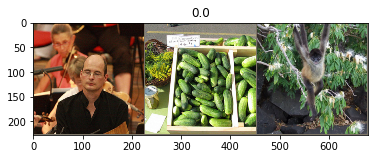

using augmentation [Resize(size=256, interpolation=PIL.Image.BILINEAR), CenterCrop(size=(224, 224)), <moco.loader.GaussianBlur object at 0x7fed93038e48>, ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
xforms <moco.loader.TwoCropsTransform object at 0x7fed930382e8>
NO KFOLD ARG None  or  False
train sampler None


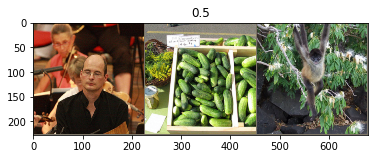

using augmentation [Resize(size=256, interpolation=PIL.Image.BILINEAR), CenterCrop(size=(224, 224)), <moco.loader.GaussianBlur object at 0x7fed96f5f358>, ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
xforms <moco.loader.TwoCropsTransform object at 0x7fed96f37a58>
NO KFOLD ARG None  or  False
train sampler None


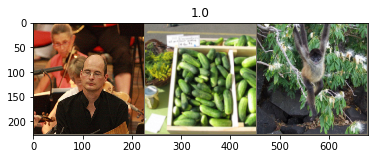

using augmentation [Resize(size=256, interpolation=PIL.Image.BILINEAR), CenterCrop(size=(224, 224)), <moco.loader.GaussianBlur object at 0x7fec69a7e4a8>, ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
xforms <moco.loader.TwoCropsTransform object at 0x7fec69a7e908>
NO KFOLD ARG None  or  False
train sampler None


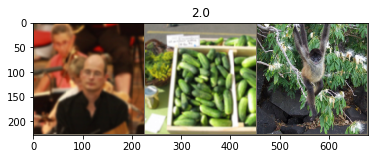

using augmentation [Resize(size=256, interpolation=PIL.Image.BILINEAR), CenterCrop(size=(224, 224)), <moco.loader.GaussianBlur object at 0x7fec69a636d8>, ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
xforms <moco.loader.TwoCropsTransform object at 0x7fec69a637f0>
NO KFOLD ARG None  or  False
train sampler None


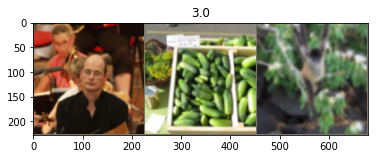

using augmentation [Resize(size=256, interpolation=PIL.Image.BILINEAR), CenterCrop(size=(224, 224)), <moco.loader.GaussianBlur object at 0x7fed9303e208>, ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
xforms <moco.loader.TwoCropsTransform object at 0x7fec69ede710>
NO KFOLD ARG None  or  False
train sampler None


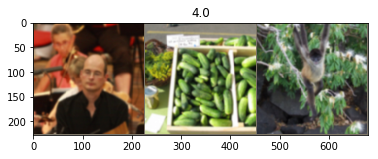

In [7]:

#!/usr/bin/env python
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import builtins
import math
import string
import os
import random
import shutil
import time
import warnings

import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from imagenet import ImageNet, SubsetSampler # Kakao brain stuff. 
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import SubsetRandomSampler, Sampler, Subset, ConcatDataset
from RandAugment import RandAugment
import slm_utils.get_faa_transforms
import moco.loader
import moco.builder
import numpy as np
import data_loader

sigmas= [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]

for sigma in sigmas: 
    class Args: 
        dataid = "imagenet"
        data = '/userdata/smetzger/data/imagenet/imagenet12/'
        aug_plus = True
        randomcrop =False
        rrc_param = .2
        faa_aug = False
        custom_aug_name = None
        sigma = sigma
        kfold = None
        reduced_imgnet = False
        distributed = False
        batch_size=3
    args = Args()


    # Cifar 10 crops and normalization.
    if args.dataid == "cifar10" or args.dataid =="svhn":
        _CIFAR_MEAN, _CIFAR_STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        normalize = transforms.Normalize(mean=_CIFAR_MEAN, std=_CIFAR_STD)
        if not args.randomcrop:
            random_resized_crop = transforms.RandomResizedCrop(28, scale=(args.rrc_param, 1.))
        else:
            # Use the crop they were using in Fast AutoAugment.
            random_resized_crop = transforms.RandomCrop(32, padding=4)

    # Use the imagenet parameters.
    elif args.dataid == "imagenet" or args.dataid == "logos":
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        random_resized_crop = transforms.RandomResizedCrop(224, scale=(0.2, 1.))


        
#     if args.aug_plus and (args.faa_aug or 
#                           args.rand_aug or args.rand_aug_orig or not(args.custom_aug_name == None)):
#         raise Exception("Cannot have multiple augs on command line")
       
    if args.aug_plus:
        # MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
        augmentation = [
#             random_resized_crop,
#             transforms.RandomApply([
#                 transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
#             ], p=0.8),
#             transforms.RandomGrayscale(p=0.2),
            # TODO is this right for cifar10?
            transforms.Resize(256),
            transforms.CenterCrop(224),
            moco.loader.GaussianBlur([args.sigma/20, args.sigma]),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ]

        
    elif not args.custom_aug_name == None: 
        augmentation, _ = slm_utils.get_faa_transforms.load_custom_transforms(name=args.custom_aug_name, randomcrop=args.randomcrop,
            aug_idx=args.single_aug_idx, dataid=args.dataid)
        
        print('using custom augs', augmentation)

        transformations = moco.loader.TwoCropsTransform(augmentation)


    else:
        # MoCo v1's aug: the same as InstDisc https://arxiv.org/abs/1805.01978
        print('using v1 augs')
        augmentation = [
#             random_resized_crop,
#             transforms.RandomGrayscale(p=0.2),
#             transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ]


    if not args.faa_aug and args.custom_aug_name == None:

        print('using augmentation', augmentation)
        transformations = moco.loader.TwoCropsTransform(transforms.Compose(augmentation))


    print('xforms', transformations)

    if args.dataid == "imagenet" and not args.reduced_imgnet:
        train_dataset = datasets.ImageFolder(
            args.data,
            transformations)

    elif args.dataid == "logos" and not args.reduced_imgnet: 
        train_dataset = data_loader.GetLoader(data_root=args.data,
        data_list='train_images_root.txt',
        transform=transformations)


    elif (args.dataid == "imagenet" or args.dataid == 'logos') and args.reduced_imgnet: 
        # idx120 = [16, 23, 52, 57, 76, 93, 95, 96, 99, 121, 122, 128, 148, 172, 181, 189, 202, 210, 232, 238, 257, 258, 259, 277, 283, 289, 295, 304, 307, 318, 322, 331, 337, 338, 345, 350, 361, 375, 376, 381, 388, 399, 401, 408, 424, 431, 432, 440, 447, 462, 464, 472, 483, 497, 506, 512, 530, 541, 553, 554, 557, 564, 570, 584, 612, 614, 619, 626, 631, 632, 650, 657, 658, 660, 674, 675, 680, 682, 691, 695, 699, 711, 734, 736, 741, 754, 757, 764, 769, 770, 780, 781, 787, 797, 799, 811, 822, 829, 830, 835, 837, 842, 843, 845, 873, 883, 897, 900, 902, 905, 913, 920, 925, 937, 938, 940, 941, 944, 949, 959]
        
        if args.dataid == "imagenet":
            total_trainset = ImageNet(root=args.data, transform=transformations) # TODO for LINCLS, make this train and test xforms.
        
        else: 
            total_trainset = data_loader.GetLoader(data_root=args.data,
                    data_list='train_images_root.txt',
                    transform=transformations)

        train_idx = np.arange(len(total_trainset))

        np.random.seed(1337) #fingers crossed. 
        np.random.shuffle(train_idx)
        train_idx = train_idx[:50000]

        kfold = args.kfold

        print('KFOLD BEING USED', kfold)
        subset = np.arange(kfold*10000, (kfold+1)*10000)
        print('start', 'end', kfold*10000, (kfold+1)*10000)
        valid_idx = train_idx[subset]
        train_idx = np.delete(train_idx, subset)

        print('first val_idx', valid_idx[:10])

        train_dataset = total_trainset

        train_dataset = Subset(train_dataset, train_idx)
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetSampler(valid_idx)

        print(len(train_dataset))
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
        print(len(train_dataset))


        print('first 10 train', train_idx[:10])
        print('first 10 valid', valid_idx[:10])
        print('len train', len(train_idx))
        print('len valid', len(valid_idx))

        for i in valid_idx: 
            if i in train_idx: 
                raise Exception("Valid idx in train idx: this is unexpected")
        print('train_sampler', train_sampler)


       
    elif args.dataid == "cifar10":
        train_dataset = torchvision.datasets.CIFAR10(args.data,
                                                     transform=transformations,
                                                     download=True)

    elif args.dataid == "svhn": 
        train_dataset = torchvision.datasets.SVHN(args.data, 
            transform=transformations, 
            download=True)
    else:
        raise NotImplementedError("Support for the following dataset is not yet implemented: {}".format(args.dataid))

    if not args.kfold == None and not args.reduced_imgnet: 
        torch.manual_seed(1337)
        print('before: K FOLD', args.kfold, len(train_dataset))
        lengths = [len(train_dataset)//5]*5
        print(lengths)
        lengths[-1] = int(lengths[-1] + (len(train_dataset)-np.sum(lengths)))
        print(lengths)
        folds = torch.utils.data.random_split(train_dataset, lengths )
        print(len(folds))
        folds.pop(args.kfold)
        print(len(folds))
        train_dataset = torch.utils.data.ConcatDataset(folds)
        print(len(train_dataset))

    else: 
        print("NO KFOLD ARG", args.kfold, ' or ', args.reduced_imgnet)
    
    if args.distributed and not args.reduced_imgnet:
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    elif not args.reduced_imgnet:
        train_sampler = None
    print('train sampler', train_sampler)

    torch.manual_seed(1337)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, 
        shuffle=(train_sampler is None), pin_memory=False,
        sampler=train_sampler, drop_last=True)

    inputs, classes = next(iter(train_loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs[0])

    imshow(out, sigma)

In [8]:
inputs, classes = next(iter(train_loader))